In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import snowflake.connector
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt


from pathlib import Path
import sys 
project_root = Path().resolve().parent
print(project_root)
sys.path.append(str(project_root))

from env_map import customer_env_map

pd.options.display.float_format = '{:,.2f}'.format


import logging

def connect_and_fetch_sf_credentials(customer_name):
    try:
        config = customer_env_map.get(customer_name)
        if not config:
            raise ValueError(f"No Snowflake configuration found for customer_id: {customer_name}")
        
        return snowflake.connector.connect(
            user=config['USER'],
            password=config['PASSWORD'],
            account=config['ACCOUNT'],
            warehouse=config['WAREHOUSE'],
            database=config['DATABASE'],
        )
    except Exception as e:
        logging.error(f"Snowflake connection error for '{customer_name}': {e}", exc_info=True)
        raise  

    
customer = 'dev1-wex'
customer = customer.lower()
CSP = 'aws'
CSP = CSP.upper()
conn = connect_and_fetch_sf_credentials(customer_name=customer)
cs = conn.cursor()



current_month = datetime.now().strftime("%Y%m")

# Fetch data for each B|U as well as the children under it Union with total
fetch_merged_costs = f"""
WITH CHILD_BUS AS (
    SELECT DISTINCT
        ROOT_BU_ID,
        BU_ID
    FROM APP.VW_BUSINESS_UNITS_HIERARCHY
    WHERE ROOT_BU_ID NOT IN (SELECT DISTINCT FO_BUSINESS_UNIT_ID 
                             FROM APP.BUSINESS_UNITS
                             WHERE IS_ALL_BU = TRUE)
),
BU_CTE AS (
    SELECT FO_BUSINESS_UNIT_ID, BUSINESS_UNIT_NAME
    FROM APP.BUSINESS_UNITS
    WHERE IS_UNALLOCATED_BU = FALSE
)

-- Combined query for total + BU-level spend
SELECT 
    CBU.ROOT_BU_ID AS BU_ID,
    BU.BUSINESS_UNIT_NAME,
    A.MONTH,
    SUM(A.COST) AS MONTHLY_SPENT
FROM APP.CHARGEBACK AS A
INNER JOIN CHILD_BUS AS CBU 
    ON A.BUSINESS_UNIT_ID = CBU.BU_ID
INNER JOIN BU_CTE BU
    ON CBU.ROOT_BU_ID = BU.FO_BUSINESS_UNIT_ID
WHERE 
    UPPER(A.CSP) = '{CSP}'
    AND A.MONTH <> {current_month}
GROUP BY 
    CBU.ROOT_BU_ID,
    BU.BUSINESS_UNIT_NAME,
    A.MONTH

UNION ALL

SELECT 
    (SELECT FO_BUSINESS_UNIT_ID FROM APP.BUSINESS_UNITS WHERE IS_ALL_BU = TRUE) AS BU_ID,
    (SELECT BUSINESS_UNIT_NAME FROM APP.BUSINESS_UNITS WHERE IS_ALL_BU = TRUE) AS BUSINESS_UNIT_NAME,
    MONTH,
    SUM(COST) AS MONTHLY_SPENT
FROM APP.CHARGEBACK
WHERE 
    UPPER(CSP) = '{CSP}'
    AND MONTH <> {current_month}
GROUP BY MONTH

ORDER BY BU_ID, MONTH;
"""             
bu_cost_df = cs.execute(command=fetch_merged_costs).fetch_pandas_all()
bu_cost_df['MONTH'] = pd.to_datetime(arg=bu_cost_df['MONTH'].astype(str), format='%Y%m')
bu_cost_df['MONTHLY_SPENT'] = pd.to_numeric(arg=bu_cost_df['MONTHLY_SPENT'], errors='coerce')
bu_cost_df = bu_cost_df.sort_values(["BU_ID", "MONTH"]).reset_index(drop=True)
# Marking BUs with only 4 or more months of data ( we will only forecast for those)
month_counts = (
    bu_cost_df.groupby("BU_ID")["MONTH"]
    .nunique()
    .reset_index(name="MONTH_COUNT")
)

long_history_threshold = 4

month_counts["IS_LONG_HISTORY"] = month_counts["MONTH_COUNT"] >= long_history_threshold

fetch_all_bu_names = """
                        SELECT 
                            FO_BUSINESS_UNIT_ID AS BU_ID, 
                            BUSINESS_UNIT_NAME,
                            CASE 
                                WHEN IS_ALL_BU = TRUE THEN 'TOTAL'
                                ELSE 'BU Level'
                            END AS LEVEL
                        FROM APP.BUSINESS_UNITS
                        WHERE IS_UNALLOCATED_BU = FALSE OR IS_ALL_BU = TRUE
                    """
df_bu = cs.execute(fetch_all_bu_names).fetch_pandas_all()
df_bu =  df_bu.merge(
                month_counts[["BU_ID", "IS_LONG_HISTORY"]],
                on="BU_ID",
                how="left"
            )
df_bu["IS_LONG_HISTORY"] = df_bu["IS_LONG_HISTORY"].where(df_bu["IS_LONG_HISTORY"].notna(), False).astype(bool)
df_bu = df_bu.sort_values(["BU_ID"]).reset_index(drop=True)
print(len(bu_cost_df))
df_bu


C:\Users\Aksha\Desktop\Akshaj Finopsly\Github\Budget-Forecast
3009


,BU_ID,BUSINESS_UNIT_NAME,LEVEL,IS_LONG_HISTORY
0,1,Wex-All Business Units,TOTAL,True
1,16,AI Platform,BU Level,True
2,17,Architecture,BU Level,True
3,18,Architecture.,BU Level,True
4,20,Encompass,BU Level,True
...,...,...,...,...
419,1871,WEX Data Lake Prod,BU Level,True
420,1872,WEX Data Lake Dev,BU Level,True
421,1874,onewex-identity-stage,BU Level,False
422,1875,onewex-identity-prod,BU Level,False


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing



def fit_and_forecast(df, forecast_period=12, is_log=False):
    """
    Fits a Holt-Winters model and returns a forecast Series.
    is_log=True means forecast uses LOG_SPENT column and converts back via expm1.
    """
    
    series_name = 'LOG_SPENT' if is_log else 'MONTHLY_SPENT'
    
    model = ExponentialSmoothing(
        df[series_name],
        trend='add',
        seasonal=None,
        damped_trend=True
    )

    fitted = model.fit(
        smoothing_level=0.6,
        smoothing_trend=0.5,
        damping_trend=0.8,
        optimized=False
    )
    
    # Build forecast index
    last_month = df.index.max()
    forecast_index = pd.date_range(
        start=last_month + pd.offsets.MonthBegin(1),
        periods=forecast_period,
        freq='MS'
    )

    forecast = fitted.forecast(forecast_period)
    forecast.index = forecast_index

    # Convert back to original scale if log model was used
    if is_log:
        forecast = np.expm1(forecast)

    return forecast



def forecast_monthly_spent_long(bu_id, temp, periods=12):
    temp = temp.copy()
    temp.set_index('MONTH', inplace=True)
    temp.index = pd.to_datetime(temp.index)
    temp = temp.asfreq('MS')

    forecast = fit_and_forecast(temp, forecast_period=periods)

    recent_mean = (
        temp['MONTHLY_SPENT'].tail(3).mean()
        if len(temp) >= 3
        else temp['MONTHLY_SPENT'].mean()
    )

    # Refit if forecast collapses too much
    if forecast.mean() < 0.6 * recent_mean or forecast.min() < 0.4 * recent_mean:

        temp['LOG_SPENT'] = np.log1p(temp['MONTHLY_SPENT'])
        forecast = fit_and_forecast(temp, forecast_period=periods, is_log=True)

        trend_slope = temp['MONTHLY_SPENT'].diff().mean()

        # Floor logic
        if trend_slope < 0 and temp['MONTHLY_SPENT'].iloc[-1] < (recent_mean * 0.5):
            floor = 0
        else:
            floor = max(
                temp['MONTHLY_SPENT'].iloc[-1] * 0.05,
                recent_mean * 0.02,
                0
            )

        forecast = forecast.clip(lower=floor)
        
    actual_df = (
        temp[['MONTHLY_SPENT']]
        .rename(columns={'MONTHLY_SPENT': 'SPEND'})
        .assign(IS_FORECAST=False)
    )

    forecast_df = (
        forecast.to_frame(name='SPEND')
        .assign(IS_FORECAST=True)
    )

    combined_df = pd.concat([actual_df, forecast_df], axis=0)

    combined_df['BU_ID'] = bu_id
    combined_df = combined_df.reset_index().rename(columns={'index': 'MONTH'})

    return combined_df

def complete_time_series(temp):
    """
    Ensures continuous monthly data for a single BU.
    Missing months are added with MONTHLY_SPENT = 0.
    """
    # Full monthly index for this BU
    full_idx = pd.date_range(
        start=temp["MONTH"].min(),
        end=temp["MONTH"].max(),
        freq="MS"
    )

    # Reindex on MONTH
    completed = (
        temp.set_index("MONTH")
            .reindex(full_idx)
            .rename_axis("MONTH")
            .reset_index()
    )

    # Fill BU ID and BU name
    completed["BU_ID"] = temp["BU_ID"].iloc[0]
    completed["BUSINESS_UNIT_NAME"] = temp["BUSINESS_UNIT_NAME"].iloc[0]

    # Fill missing spent with 0
    completed["MONTHLY_SPENT"] = completed["MONTHLY_SPENT"].fillna(0)

    return completed


def plot_time_series(df, bu_name, periods=12):
    plt.figure(figsize=(10, 6))

    # Separate actuals and forecast
    actual = df[~df['IS_FORECAST']]
    forecast = df[df['IS_FORECAST']]

    # Plot actuals
    plt.plot(
        actual['MONTH'],
        actual['SPEND'],
        label='Actual',
        marker='o'
    )

    # Plot forecast if it exists
    if not forecast.empty:
        plt.plot(
            forecast['MONTH'],
            forecast['SPEND'],
            label=f'Forecast (Next {periods} Months)',
            marker='x',
            linestyle='--'
        )

        max_ylim = max(
            actual['SPEND'].max() * 1.2,
            forecast['SPEND'].max() * 1.2,
            1
        )
    else:
        max_ylim = max(actual['SPEND'].max() * 1.2, 1)

    plt.title(f'{periods}-Month Forecast of Monthly Spent for {bu_name}')
    plt.xlabel('Month')
    plt.ylabel('Monthly Spent')
    plt.ylim(0, max_ylim)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def clip_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df.copy()
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df



=== Forecast for Shared Tech (BU_ID: 26) ===
        MONTH  SPEND  IS_FORECAST  BU_ID
0  2025-03-01 665.07        False     26
1  2025-04-01 603.28        False     26
2  2025-05-01 612.87        False     26
3  2025-06-01 546.92        False     26
4  2025-07-01 625.37        False     26
5  2025-08-01 696.59        False     26
6  2025-09-01 618.98        False     26
7  2025-10-01 656.61        False     26
8  2025-11-01 644.93        False     26
9  2025-12-01 661.06        False     26
10 2026-01-01 683.66        False     26
11 2026-02-01 682.41         True     26
12 2026-03-01 688.86         True     26
13 2026-04-01 694.01         True     26
14 2026-05-01 698.14         True     26
15 2026-06-01 701.44         True     26
16 2026-07-01 704.08         True     26
17 2026-08-01 706.19         True     26
18 2026-09-01 707.88         True     26
19 2026-10-01 709.24         True     26
20 2026-11-01 710.32         True     26
21 2026-12-01 711.18         True     26
22 2027-01-

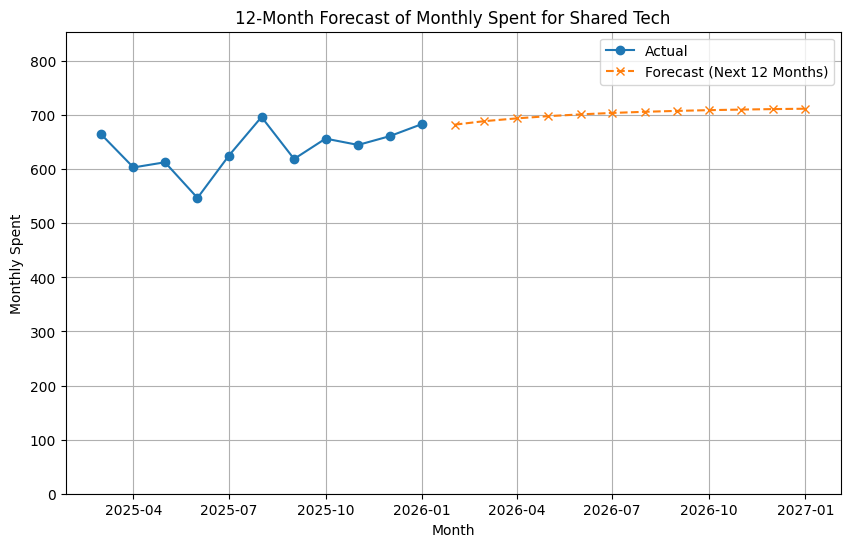


Exiting forecast loop...


In [15]:
from IPython.display import clear_output

# List of BU_IDs where IS_LONG_HISTORY == True
bu_list = df_bu.loc[df_bu['IS_LONG_HISTORY'], 'BU_ID'].to_list()
forecast_periods = 12

for bu_id in bu_list:
    row = df_bu[df_bu["BU_ID"] == bu_id].iloc[0]
    bu_name = row["BUSINESS_UNIT_NAME"]

    # Extract BU dataset
    temp = bu_cost_df[bu_cost_df["BU_ID"] == bu_id].copy()
    
    temp["MONTH"] = pd.to_datetime(temp["MONTH"])
    # Clean Data and complete Time Series
    temp = complete_time_series(temp)
    # --- SAFETY CHECKS ---
    
    #No Negative Values
    temp["MONTHLY_SPENT"] = temp["MONTHLY_SPENT"].clip(lower=0)
    # 1. Check if it is empty
    if temp.empty:
        print(f"No data available for BU_ID: {bu_id}")
        continue
    
    # 2. Check if the max value is Zero then give all future values zero  
    if temp["MONTHLY_SPENT"].max() == 0:
        print(f"\n=== Forecast for {bu_name} (BU_ID: {bu_id}) ===")
        print("All historical values are zero → Forecasting zeros.")

        last_month = temp['MONTH'].max()
        forecast_index = pd.date_range(
            start=last_month + pd.offsets.MonthBegin(1),
            periods=forecast_periods,
            freq='MS'
        )

        zero_forecast = pd.DataFrame({
            "MONTH": forecast_index,
            "FORECASTED_SPENT": [0] * forecast_periods
        })

        print(zero_forecast)
        plot_time_series(df=temp, forecast = zero_forecast, bu_name = bu_name, periods =forecast_periods)
        user_input = input("\nPress Enter to continue, or type 'q' to quit: ")
        if user_input.strip().lower() == 'q':
            print("\nExiting forecast loop...")
            break

        clear_output(wait=True)
        continue
    # Clipping Outliers 
    temp= clip_outliers_iqr(temp, "MONTHLY_SPENT")

    # --- NORMAL FORECASTING ---
    print(f"\n=== Forecast for {bu_name} (BU_ID: {bu_id}) ===")
    forecast = forecast_monthly_spent_long(bu_id=bu_id, temp=temp, periods=forecast_periods)
    print(forecast)
    
    plot_time_series(
            df=forecast,
            bu_name=bu_name,
            periods=forecast_periods
        )
    
    user_input = input("\nPress Enter to continue, or type 'q' to quit: ")
    if user_input.strip().lower() == 'q':
        print("\nExiting forecast loop...")
        break

    clear_output(wait=True)
